# Introduction

The following notebook contains a data story that examines a [Kaggle dataset](https://www.kaggle.com/unsdsn/world-happiness) on the [World Happiness Report’s](https://worldhappiness.report/) data on global happiness by country and other possible influencing factors such as Gini index (a measure of wealth inequality) and population growth. The data used in this notebook for Gini index and population growth come from datasets from [the World Bank.](https://data.worldbank.org/) The data story seeks to explore what makes one country happier than another by examining how population growth and wealth inequality impact happiness.

# Data Preparation

In order to create useful visualizations, the data raw data needs to be processed into a usable format. To do this I mainly relied on reading the csv files containing the WHR (World Happiness Report) data into pandas dataframes. The columns in the dataframe were then renamed to fit a consistent format (the world happiness report changed the column names nearly every year), countries with inconsistent data were filtered out, and country codes added to allow for clarity in merging dataframes. A similar process was conducted for the World Bank data before the five WHR datasets were merged with the 2 World Bank datasets. Other modifications (like removing the Gini Index_2019 due to lack of data) were also made to ensure that only data useful to the project was included.

### *Clean and Prepare World Happiness Report*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pycountry_convert as pc
import seaborn as sns

In [2]:
# dictionary containing all WHR datasets
WHR = {
    "2015":pd.read_csv('WHR_2015.csv'),
    "2016":pd.read_csv('WHR_2016.csv'),
    "2017":pd.read_csv('WHR_2017.csv'),
    "2018":pd.read_csv('WHR_2018.csv'),
    "2019":pd.read_csv('WHR_2019.csv')
}

# Make 2015 consistent with other datasets
WHR['2015'] = WHR['2015'].drop(['Region','Standard Error','Dystopia Residual'],axis=1)
WHR['2015'].rename(columns={'Economy (GDP per Capita)': 'GDP per capita','Health (Life Expectancy)':'Life Expectancy'}, inplace=True)
WHR['2015'].rename(columns={'Trust (Government Corruption)':'Perceptions of Corruption','Family':'Social Support'}, inplace=True)

# Make 2016 consistent with other datasets
WHR['2016'] = WHR['2016'].drop(['Region','Lower Confidence Interval','Upper Confidence Interval','Dystopia Residual'],axis=1)
WHR['2016'].rename(columns={'Economy (GDP per Capita)': 'GDP per capita','Health (Life Expectancy)':'Life Expectancy'}, inplace=True)
WHR['2016'].rename(columns={'Trust (Government Corruption)':'Perceptions of Corruption','Family':'Social Support'}, inplace=True)

# Make 2017 consistent with other datasets
WHR['2017'] = WHR['2017'].drop(['Whisker.high','Whisker.low','Dystopia.Residual'],axis=1)
WHR['2017'].rename(columns={'Happiness.Rank': 'Happiness Rank','Happiness.Score':'Happiness Score'}, inplace=True)
WHR['2017'].rename(columns={'Economy..GDP.per.Capita.': 'GDP per capita','Family':'Social Support'}, inplace=True)
WHR['2017'].rename(columns={'Health..Life.Expectancy.': 'Life Expectancy','Trust..Government.Corruption.':'Perceptions of Corruption'}, inplace=True)

# Make 2018 consistent with other datasets
WHR['2018'].rename(columns={'Country or region': 'Country'}, inplace=True)
WHR['2018'].rename(columns={'Overall rank': 'Happiness Rank','Score':'Happiness Score','Freedom to make life choices': 'Freedom'}, inplace=True)
WHR['2018'].rename(columns={'Social support': 'Social Support','Healthy life expectancy':'Life Expectancy', 'Perceptions of corruption':'Perceptions of Corruption'}, inplace=True)

# Make 2019 consistent with other datasets
WHR['2019'].rename(columns={'Country or region': 'Country'}, inplace=True)
WHR['2019'].rename(columns={'Overall rank': 'Happiness Rank','Score':'Happiness Score','Freedom to make life choices': 'Freedom'}, inplace=True)
WHR['2019'].rename(columns={'Social support': 'Social Support','Healthy life expectancy':'Life Expectancy', 'Perceptions of corruption':'Perceptions of Corruption'}, inplace=True)

In [3]:
# see which countries are present throughout the dataset
total_countries = dict()
for year in WHR:
    countries = list(WHR[year]['Country'])
    for country in countries:
        if country not in total_countries:
            total_countries[country] = 1
        else:
            total_countries[country] += 1
            
# total_countries should have list the number of datasets that each country appears in (5 means there is data throughout)
valid_countries = []
for country in total_countries:
    if total_countries[country] == 5:
        valid_countries.append(country) # valid_countries contains the 141 countries present throughout the five datasets
        
# filters out all countries that are not in valid_countries
for year in WHR:
    boolean_series = WHR[year].Country.isin(valid_countries)
    WHR[year] = WHR[year][boolean_series]

In [4]:
# Get country codes from country names
import country_converter as coco
def get_country_codes(df,country_column):
    codes = []
    for country in df[country_column]:
        try:
            if country == 'Côte d':
                country = 'ivory coast'
            elif country == 'S. Sudan':
                country = 'South Sudan'
                
            code = coco.convert(country, to='ISO3')
            codes.append(code)
        except:
            codes.append('None')
    df['Country_Code'] = codes
    
for year in WHR:
    get_country_codes(WHR[year], "Country")

### *Clean and Prepare World Bank*

In [5]:
gini = pd.read_csv('gini.csv')
growth = pd.read_csv('population_growth.csv')

In [6]:
# drop irrelevant years and columns

columns_to_drop = ['Indicator Name','Indicator Code','2020','Unnamed: 65']

years_to_drop = [str(year) for year in range(1960,2015)]
columns_to_drop = columns_to_drop + years_to_drop

gini = gini.drop(columns_to_drop, axis=1) # gini is missing data for 2019
growth = growth.drop(columns_to_drop,axis=1)

In [7]:
# rename Country Code
gini.rename(columns={"Country Code":"Country_Code"}, inplace=True)
growth.rename(columns={"Country Code":"Country_Code"}, inplace=True)

### *Merge World Bank and World Happiness*

In [8]:
# takes dictionary of dbs then merges each year for both datasets
def merge_across_year(db_dict, world_bank, new_column_name):
    for year in db_dict:
        db_dict[year] = db_dict[year].merge(world_bank[['Country_Code',year]], how='left', on='Country_Code')
        db_dict[year].rename(columns={year:new_column_name}, inplace=True)
    
merge_across_year(WHR, gini, 'Gini Index')
merge_across_year(WHR, growth, 'Population Growth')

In [9]:
WHR['2016'].sort_values('Country')

,Country,Happiness Rank,Happiness Score,GDP per capita,Social Support,Life Expectancy,Freedom,Perceptions of Corruption,Generosity,Country_Code,Gini Index,Population Growth
137,Afghanistan,154,3.360,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,AFG,NaN,2.778317
97,Albania,109,4.655,0.95530,0.50163,0.73007,0.31866,0.05301,0.16840,ALB,33.7,-0.159880
35,Algeria,38,6.355,1.05266,0.83309,0.61804,0.21006,0.16157,0.07044,DZA,NaN,2.051355
24,Argentina,26,6.650,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,ARG,42.0,1.057182
108,Armenia,121,4.360,0.86086,0.62477,0.64083,0.14037,0.03616,0.07793,ARM,32.5,0.361431
...,...,...,...,...,...,...,...,...,...,...,...,...
39,Venezuela,44,6.084,1.13367,1.03302,0.61904,0.19847,0.08304,0.04250,VEN,NaN,-0.786448
86,Vietnam,96,5.061,0.74037,0.79117,0.66157,0.55954,0.11556,0.25075,VNM,35.3,1.032287
130,Yemen,147,3.724,0.57939,0.47493,0.31048,0.22870,0.05892,0.09821,YEM,NaN,2.498247
94,Zambia,106,4.795,0.61202,0.63760,0.23573,0.42662,0.11479,0.17866,ZMB,NaN,3.003346


### *Merge All Years into Single Dataset*

In [10]:
df = WHR['2015'].merge(WHR['2016'].loc[:, WHR['2016'].columns != 'Country'], how='inner', on='Country_Code', suffixes=('', '_2016'))
df = df.merge(WHR['2017'].loc[:, WHR['2017'].columns != 'Country'], how='inner', on='Country_Code', suffixes=('','_2017'))
df = df.merge(WHR['2018'].loc[:, WHR['2018'].columns != 'Country'], how='inner', on='Country_Code', suffixes=('','_2018'))
df = df.merge(WHR['2019'].loc[:, WHR['2019'].columns != 'Country'], how='inner', on='Country_Code', suffixes=('_2015','_2019'))

# WHR['2019'].loc[:, WHR['2019'].columns != 'Country'] selects all columns except country to avoid country_2016 

In [11]:
df

,Country,Happiness Rank_2015,Happiness Score_2015,GDP per capita_2015,Social Support_2015,Life Expectancy_2015,Freedom_2015,Perceptions of Corruption_2015,Generosity_2015,Country_Code,...,Happiness Rank_2019,Happiness Score_2019,GDP per capita_2019,Social Support_2019,Life Expectancy_2019,Freedom_2019,Generosity_2019,Perceptions of Corruption_2019,Gini Index_2019,Population Growth_2019
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,CHE,...,6,7.480,1.452,1.526,1.052,0.572,0.263,0.343,NaN,0.708089
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,ISL,...,4,7.494,1.380,1.624,1.026,0.591,0.354,0.118,NaN,2.406724
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,DNK,...,2,7.600,1.383,1.573,0.996,0.592,0.252,0.410,NaN,0.429153
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,NOR,...,3,7.554,1.488,1.582,1.028,0.603,0.271,0.341,NaN,0.675061
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,CAN,...,9,7.278,1.365,1.505,1.039,0.584,0.285,0.308,NaN,1.424051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Rwanda,154,3.465,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,RWA,...,152,3.334,0.359,0.711,0.614,0.555,0.217,0.411,NaN,2.607653
137,Benin,155,3.340,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,BEN,...,102,4.883,0.393,0.437,0.397,0.349,0.175,0.082,NaN,2.715105
138,Syria,156,3.006,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,SYR,...,149,3.462,0.619,0.378,0.440,0.013,0.331,0.141,NaN,0.964512
139,Burundi,157,2.905,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,BDI,...,145,3.775,0.046,0.447,0.380,0.220,0.176,0.180,NaN,3.128967


In [12]:
# drop Gini Index 2019 for lack of data
df = df.drop(['Gini Index_2019'], axis=1)

# Data Available

The first visualizations I chose to create were a series of maps showing where the World Happiness Report’s data was available across the span of (2015-2019). These maps were created using the Geopandas library and involved importing further country specific data like shapefiles, and coordinates to allow for the maps to generate. A new dataframe called geo_df (as opposed to the standard dataframe simply called df) was created with additional columns like coordinates and rows corresponding to countries missing from the WHR data to ensure that each country not present in the WHR data is represented on the maps. 

In [13]:
# Merge gdf file onto df on country code
import geopandas as gpd
shapefile = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
shapefile = shapefile.drop(index=160, axis=0) # remove northern cyprus (has same iso_a3 code as Cyrpus and causes confusion)
shapefile = shapefile.drop(index=159, axis=0) # remove antarctica

bad_codes = shapefile[shapefile.iso_a3 == '-99'] # bad_codes are countries that the shapefile has no iso_a3 code for

def shape_fix(bad_code_list, shapefile):
    """Corrects missing codes for countries in the shapefile such as Norway and France"""
    for index in bad_code_list:
        shapefile.at[index, 'iso_a3'] = coco.convert(shapefile.loc[index]['name'], to='ISO3')

bad_codes = shapefile[shapefile.iso_a3 == '-99']
shape_fix(list(bad_codes.index), shapefile)

In [14]:
shapefile.columns = ['Population', 'Continent', 'Country', 'Country_Code', 'GDP_Per_Cap', 'geometry']

just_continent = shapefile[['Continent','Country_Code',]]
adj_shapefile = shapefile[['Continent','Country_Code','geometry']]

# df will be used for future data analysis
# geo_df will be used for maps

geo_df = df.merge(adj_shapefile, how='outer', on='Country_Code')
df = df.merge(just_continent, how='left', on='Country_Code')

In [15]:
# fix missing continents for countries like Malta, Bahrain, and Singapore

# singapore is nan continent
# Malta is nan
# Bahrain is nan 
# Mauritius is nan

bad_continents = df[df['Continent'].isnull()] # bad_continents are countries that have no continents

continent_dict ={
    "AS":"Asia",
    "AF":"Africa",
    "EU":"Europe",
    "SA":"South America", 
    "NA":"North America",
    "OC":"Oceania"
}

def fix_missing_continents(bad_continent_list, df):
    """Corrects missing continent for countries in the shapefile such as Malta and Bahrain"""
    for index in bad_continent_list:
        country_code = pc.country_name_to_country_alpha2(df.loc[index]['Country'], cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent = continent_dict[continent_code]
        df.at[index, 'Continent'] = continent
        
fix_missing_continents(list(bad_continents.index), df)

In [16]:
# add longitude and lattitude for map visualization
location = pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
get_country_codes(location,'name')
location = location[['latitude','longitude','Country_Code']]
geo_df = geo_df.merge(location, how='left', on='Country_Code')

In [17]:
df

,Country,Happiness Rank_2015,Happiness Score_2015,GDP per capita_2015,Social Support_2015,Life Expectancy_2015,Freedom_2015,Perceptions of Corruption_2015,Generosity_2015,Country_Code,...,Happiness Rank_2019,Happiness Score_2019,GDP per capita_2019,Social Support_2019,Life Expectancy_2019,Freedom_2019,Generosity_2019,Perceptions of Corruption_2019,Population Growth_2019,Continent
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,CHE,...,6,7.480,1.452,1.526,1.052,0.572,0.263,0.343,0.708089,Europe
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,ISL,...,4,7.494,1.380,1.624,1.026,0.591,0.354,0.118,2.406724,Europe
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,DNK,...,2,7.600,1.383,1.573,0.996,0.592,0.252,0.410,0.429153,Europe
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,NOR,...,3,7.554,1.488,1.582,1.028,0.603,0.271,0.341,0.675061,Europe
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,CAN,...,9,7.278,1.365,1.505,1.039,0.584,0.285,0.308,1.424051,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Rwanda,154,3.465,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,RWA,...,152,3.334,0.359,0.711,0.614,0.555,0.217,0.411,2.607653,Africa
137,Benin,155,3.340,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,BEN,...,102,4.883,0.393,0.437,0.397,0.349,0.175,0.082,2.715105,Africa
138,Syria,156,3.006,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,SYR,...,149,3.462,0.619,0.378,0.440,0.013,0.331,0.141,0.964512,Asia
139,Burundi,157,2.905,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,BDI,...,145,3.775,0.046,0.447,0.380,0.220,0.176,0.180,3.128967,Africa


In [18]:
def check_existing_data(dataframe, column_names, new_column_name): # variable example: Happiness Score (without _2015)
    """Finds whether or not values exist in a given column"""
    data_counter = 0 # this acts as an empty series
    for column in column_names:
        data_counter += dataframe[column].apply(lambda x: 1 if not math.isnan(x) else 0)
    
    data_counter = data_counter.apply(lambda x: 'Complete' if x >= len(column_names) else ('Missing Some Values' if x > 0 else 'None'))
    dataframe[new_column_name] = data_counter
    
    
    
happiness_columns = ['Happiness Score_2015','Happiness Score_2016','Happiness Score_2017','Happiness Score_2018','Happiness Score_2019']
gini_columns = ['Gini Index_2015','Gini Index_2016','Gini Index_2017','Gini Index_2018']
pop_growth_columns = ['Population Growth_2015','Population Growth_2016','Population Growth_2017','Population Growth_2018','Population Growth_2019']

check_existing_data(geo_df, happiness_columns, "Happiness Score_Exists")
check_existing_data(geo_df, gini_columns, "Gini Index_Exists")
check_existing_data(geo_df, pop_growth_columns, "Population Growth_Exists")

The first map shows which countries have five years’ worth of WHR data, the second shows which of the countries present in the WHR have population growth data while the third shows which countries have Gini index data.

The first notable implication of the three maps are that population growth data and WHR data are present throughout the world, but are less available for African countries like Sudan or the Central African Republic. A second take away from these maps is that Gini Index data is far harder to come across. Few African countries have any data at all and the only consistent data (from 2015 to 2018) comes from Latin America and parts of Eastern Europe. This can largely be explained through the [difficultly]( https://www.brookings.edu/opinions/how-much-do-we-really-know-about-inequality-within-countries-around-the-world/) in collecting Gini index data, especially in countries where tax data is less present.


Text(0.5, 1, 'Countries with World Happiness Report data (2015-2019)')

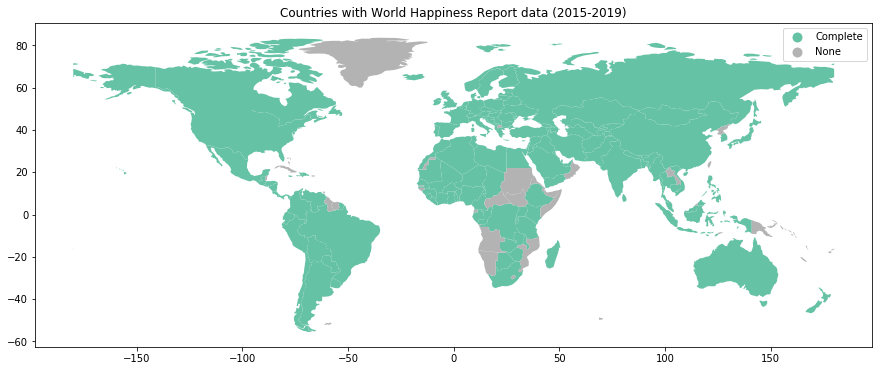

In [19]:
geo_df = gpd.GeoDataFrame(geo_df)
WHR_map = geo_df.plot(column='Happiness Score_Exists', cmap='Set2', figsize=(15, 10), legend=True)
WHR_map.set_title("Countries with World Happiness Report data (2015-2019)")

Text(0.5, 1, 'Countries with Population Growth data (2015-2019)')

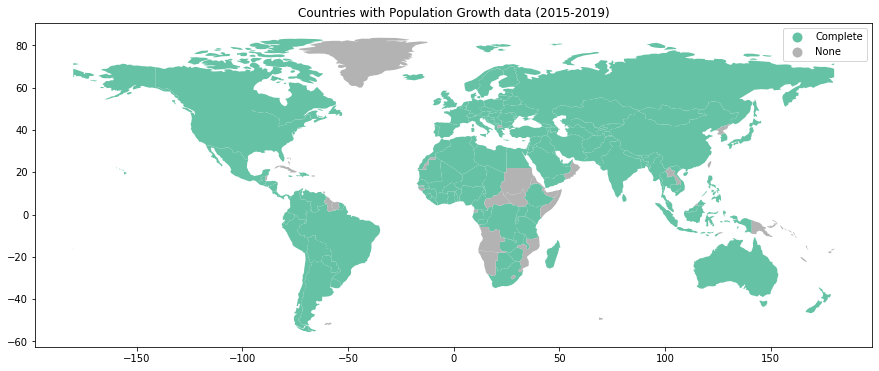

In [20]:
pop_growth_map = geo_df.plot(column='Population Growth_Exists', cmap='Set2', figsize=(15, 10), legend=True)
pop_growth_map.set_title("Countries with Population Growth data (2015-2019)")

Text(0.5, 1, 'Countries with GINI Index data (2015-2018)')

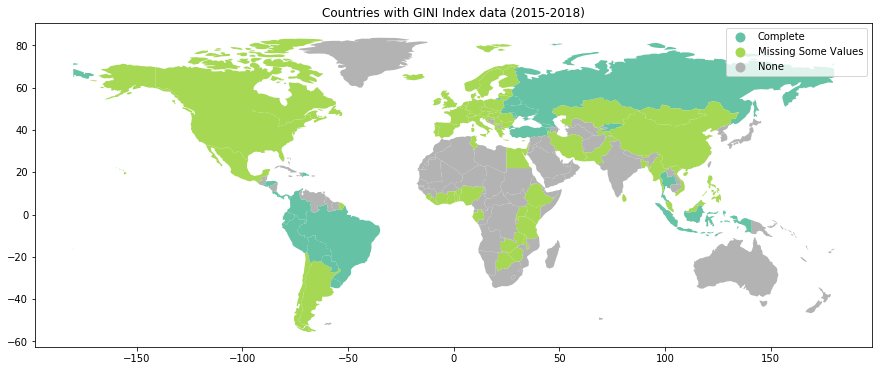

In [21]:
gini_index_map = geo_df.plot(column='Gini Index_Exists', cmap='Set2', figsize=(15, 10), legend=True)
gini_index_map.set_title("Countries with GINI Index data (2015-2018)")

# Summary Statistics

After visualizing where the data is located, I decided to display summary statistics in order to provide information about critical metrics present in the dataset. These summary statistics include mean, median, minimum value, maximum value, and standard deviation. Value counts for continents have also been calculated.

In [22]:
columns = ['df_column_name','Mean', 'Median', 'Miniumn', 'Maximum', 'Standard Deviation']
summary_statistics = pd.DataFrame(columns=columns)

# these columns do not need to be summarized
no_summary_columns = ['Country', 'Country_Code', 'Continent', 'Gini Index_2019'] 

for column in df.columns:
    if column not in no_summary_columns:
        new_row = {}
        new_row['df_column_name'] = column
        new_row['Mean'] = df[column].mean()
        new_row['Median'] = df[column].median()
        new_row['Miniumn'] = df[column].min()
        new_row['Maximum'] = df[column].max()
        new_row['Standard Deviation'] = df[column].std()
        summary_statistics.loc[len(summary_statistics.index)] = new_row

summary_statistics.sort_values("df_column_name")

,df_column_name,Mean,Median,Miniumn,Maximum,Standard Deviation
5,Freedom_2015,0.430532,0.434770,0.0,0.66973,0.149151
15,Freedom_2016,0.371758,0.392370,0.0432,0.60848,0.141085
25,Freedom_2017,0.412903,0.437454,0.03037,0.658249,0.145071
35,Freedom_2018,0.458851,0.481000,0.025,0.724,0.156164
45,Freedom_2019,0.395511,0.426000,0.0,0.631,0.142888
2,GDP per capita_2015,0.860514,0.920490,0.0,1.69042,0.395357
12,GDP per capita_2016,0.963449,1.030320,0.05661,1.82427,0.407194
22,GDP per capita_2017,1.002182,1.074988,0.091623,1.870766,0.407749
32,GDP per capita_2018,0.908638,0.975000,0.069,2.096,0.381668
42,GDP per capita_2019,0.928078,0.987000,0.046,1.684,0.381611


In [23]:
continent_count = pd.DataFrame(df["Continent"].value_counts(dropna=False))
continent_count

,Continent
Asia,42
Europe,39
Africa,36
North America,12
South America,10
Oceania,2


# Connection between Happiness and Population Growth

Population growth is an interesting area of study as it is not mentioned as one of the significant factors present in the WHR data but could potentially have an impact on global happiness. Prior to my work on the dataset my hypothesis was that higher population growth would lead to greater unhappiness as demographic changes cause discontent within a country’s borders.

### *Is there a correlation?*

The first step I took was to test for a correlation between the happiness score provided by the WHR and population growth statistics provided by the World Bank. To do this I calculated the correlation between two columns that correspond to each country’s average happiness score over the five-year span and their average population growth over that span. The results were a weak correlation of -0.339.  This result certainly does not confirm my initial hypothesis, as correlation does not mean causation and the correlation proved to be fairly weak, but it did warrant further investigation when I encoded continent as the hue of the data points.

In [24]:
# create mean over 2015-2019 span columns

def find_mean_over_time(df, column_category, time_range):
    df[f"{column_category}_mean"] = 0
    for year in time_range:
        year = str(year)
        df[f"{column_category}_mean"] += df[f"{column_category}_{year}"]
        
    df[f"{column_category}_mean"] = df[f"{column_category}_mean"]/len(time_range)
    
find_mean_over_time(df,"Population Growth",range(2015,2020))
find_mean_over_time(df,"Happiness Score",range(2015,2020))

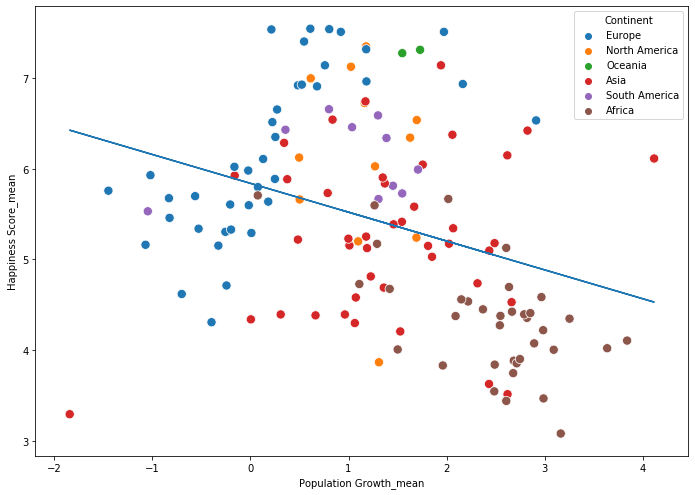

In [25]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

m, b = np.polyfit(df['Population Growth_mean'], df['Happiness Score_mean'], 1) 
plt.plot(df['Population Growth_mean'], m*df['Population Growth_mean'] + b)

sns.scatterplot(ax=ax, data=df, x='Population Growth_mean',y='Happiness Score_mean', hue='Continent', s=85)

One notable outlier on this plot is the red dot in the bottom left corner. This dot represents Syria which has been embroiled in a [years long civil war.](https://www.bbc.com/news/world-middle-east-35806229) This civil war has caused a massive amount of people to flee the country and is likely the reason why Syria is near the bottom of both population growth and unhappiness. For context neighboring countries like Iraq, Jordan, Lebanon, and Turkey have mean happiness scores of around 4.5 to 5.2.

In [26]:
correlation = df['Population Growth_mean'].corr(df['Happiness Score_mean'])
print(f"Correlation of {correlation} between population growth and happiness score")

Correlation of -0.33896963337908254 between population growth and happiness score


### *Does the correlation hold up if you split by continent?*

After encoding for continent using color on the combined scatter plot I thought it was worthwhile to split the different continents into individual scatter plots for further analysis.

In [27]:
# oceania has only two countries and is therefore not included the in the following scatterplots
# Antarctica is also discluded and is not present in the dataset

def scatter_continents(df, chosen_continent):
    solo_continent_df = df[df.Continent == chosen_continent]
    
    fig, ax = plt.subplots(figsize=(11.7, 8.27))
    plt.title(f"{chosen_continent} Population Growth and Happines Score Scatterplot")

    m, b = np.polyfit(solo_continent_df['Population Growth_mean'], solo_continent_df['Happiness Score_mean'], 1) 
    plt.plot(solo_continent_df['Population Growth_mean'], m*solo_continent_df['Population Growth_mean'] + b)
    scatter_plot = sns.scatterplot(ax=ax, data=solo_continent_df, x='Population Growth_mean',y='Happiness Score_mean', s=85)
    correlation = solo_continent_df['Population Growth_mean'].corr(solo_continent_df['Happiness Score_mean'])
    ax.annotate(f"Correlation of {correlation}", xy=(100,390), xycoords='figure points')
    return scatter_plot

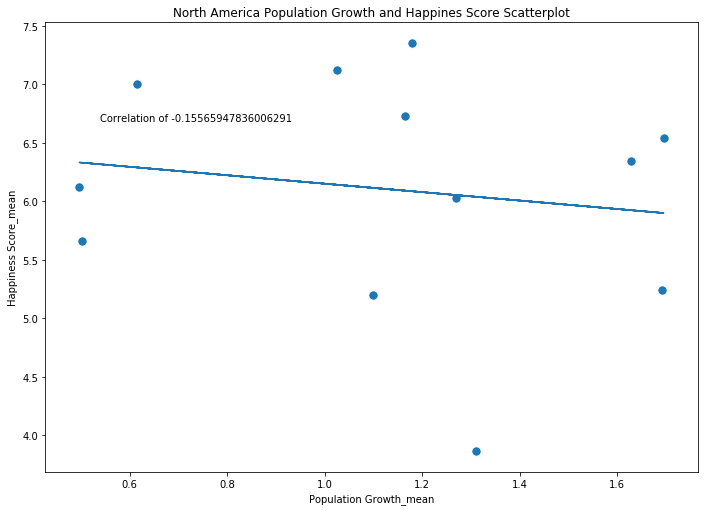

In [28]:
scatter_continents(df, "North America")

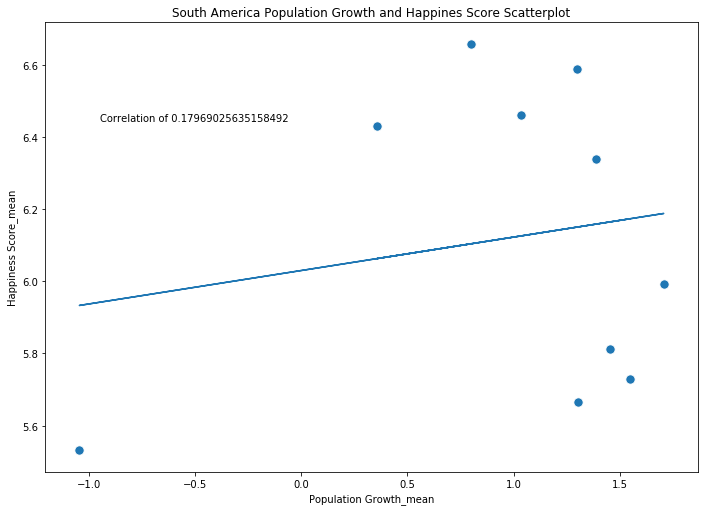

In [29]:
scatter_continents(df, "South America")

For both North America and South America little to no correlation existed between population growth and happiness. The only other observation I found worthwhile for these two plots was the status of Venezuela. Being the only South American country with a negative population growth rate ([largely due to civil unrest driving emigration]( https://www.bbc.com/news/world-latin-america-36319877)) Venezuela stands out as an outlier when compared to others on the continent. 

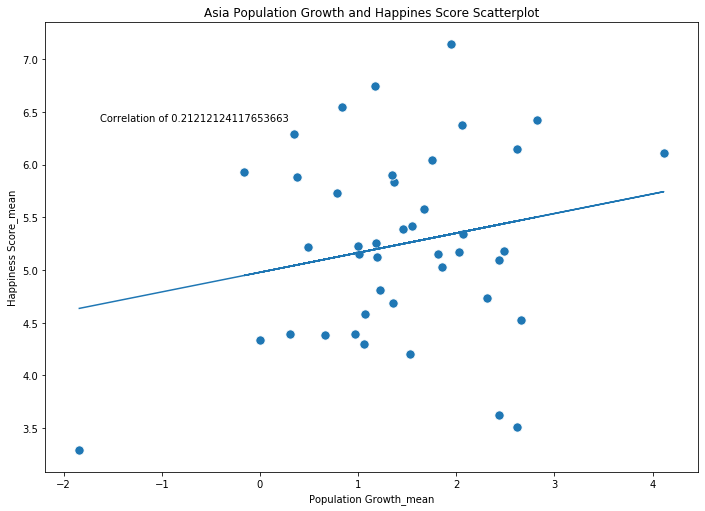

In [30]:
scatter_continents(df, "Asia")

For Asia a very small positive correlation seems to exist between population growth and happiness score. It is difficult to derive much information from this plot as Asia is the largest continent on Earth and is home to over 4.5 billion people.

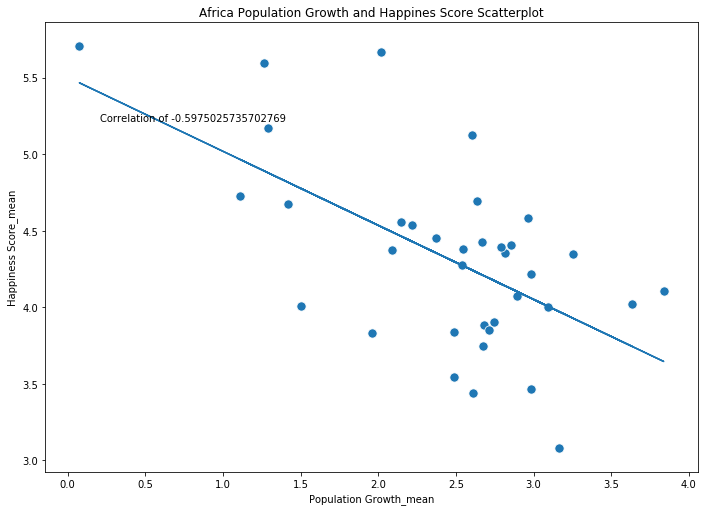

In [31]:
scatter_continents(df, "Africa")

When compared to the previous plots Africa provides the plot that most readily fits with my original hypothesis. Having a correlation of -0.597 African countries tend to score lower on happiness as population growth increases. The reasons for African population growth are [complex]( https://pubmed.ncbi.nlm.nih.gov/12283847/) but some factors that contribute to this growth include low rates of contraceptive use, and the prevalence of early marriage in the continent. This has led the continent to have the highest population growth rate in the dataset and could potentially be a contributing factor for unhappiness in the continent.

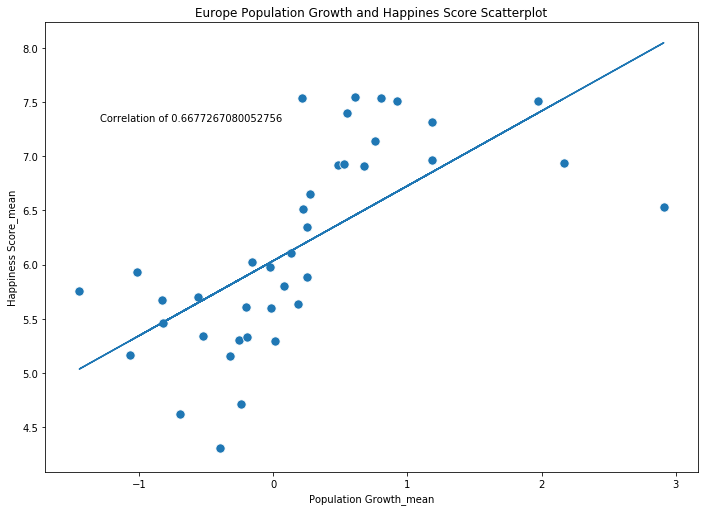

In [32]:
scatter_continents(df, "Europe")

Europe, in my view the proved to be the most surprising result. The complete opposite of my initial hypothesis, Europe has a positive correlation of .667 when comparing the two variables. After looking through the data I determined that the likely reason for this correlation is that while Western European countries like France or the United Kingdom have [relatively low birth rates]( https://ec.europa.eu/eurostat/web/products-eurostat-news/-/ddn-20210323-2) they receive many more immigrants than Eastern European countries ensuring that population growth is higher in the happier Western European countries rather than the less happy Eastern European countries. 

In [33]:
df[df.Continent == "Europe"].sort_values("Population Growth_mean",ascending=False)

,Country,Happiness Rank_2015,Happiness Score_2015,GDP per capita_2015,Social Support_2015,Life Expectancy_2015,Freedom_2015,Perceptions of Corruption_2015,Generosity_2015,Country_Code,...,GDP per capita_2019,Social Support_2019,Life Expectancy_2019,Freedom_2019,Generosity_2019,Perceptions of Corruption_2019,Population Growth_2019,Continent,Population Growth_mean,Happiness Score_mean
35,Malta,37,6.302,1.20740,1.30203,0.88721,0.60365,0.13586,0.51752,MLT,...,1.300,1.520,0.999,0.564,0.375,0.151,3.651436,Europe,2.911413,6.5340
16,Luxembourg,17,6.946,1.56391,1.21963,0.91894,0.61583,0.37798,0.28034,LUX,...,1.609,1.479,1.012,0.526,0.194,0.316,1.945908,Europe,2.164197,6.9360
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,ISL,...,1.380,1.624,1.026,0.591,0.354,0.118,2.406724,Europe,1.972094,7.5110
17,Ireland,18,6.940,1.33596,1.36948,0.89533,0.61777,0.28703,0.45901,IRL,...,1.499,1.553,0.999,0.516,0.298,0.310,1.511494,Europe,1.182545,6.9644
7,Sweden,8,7.364,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,SWE,...,1.387,1.487,1.009,0.574,0.267,0.373,1.077580,Europe,1.180116,7.3192
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,CHE,...,1.452,1.526,1.052,0.572,0.263,0.343,0.708089,Europe,0.921649,7.5114
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,NOR,...,1.488,1.582,1.028,0.603,0.271,0.341,0.675061,Europe,0.803776,7.5410
12,Austria,13,7.200,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,AUT,...,1.376,1.475,1.016,0.532,0.244,0.226,0.412540,Europe,0.759324,7.1420
20,United Kingdom,21,6.867,1.26637,1.28548,0.90943,0.59625,0.32067,0.51912,GBR,...,1.333,1.538,0.996,0.450,0.348,0.278,0.561255,Europe,0.679360,6.9100
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,DNK,...,1.383,1.573,0.996,0.592,0.252,0.410,0.429153,Europe,0.611032,7.5460


# Happiness and GINI Index

Gini index, also known as Gini coefficient is a measure of the [inequality present in a distribution]( http://www3.nccu.edu.tw/~jthuang/Gini.pdf). When examining it from an economic perspective it allows for a better understanding of how wealth is distributed. A high Gini index means more wealth inequality and a low Gini index means the opposite. In regard to global happiness my initial hypothesis was that higher wealth inequality would lead to more unhappiness as those with less would feel anger or jealously towards those with more.

### *Visualizing GINI Index Values*

To visualize how wealth inequality has changed over the time span present in my data and to show what an average Gini index would be, I decided to create a box plot that shows the Gini index from the years 2015-2018. From these box plots the median Gini index seems to be about 35 with relatively stable scores over the years. The year 2018 seems to be a spike in wealth inequality but there are also more missing countries in that year than in prior years so the lack of data could very well be skewing the results.

In [34]:
def make_column_timeseries (df,column_name1, column_name2, years, new_column_name1, new_column_name2):
    year_list = []
    for year in years:
        country_column = df['Country']
        
        first_column = df[column_name1 + "_" + year]
        second_column = df[column_name2 + "_" + year]
        
        year_df = pd.DataFrame({'Country': country_column, new_column_name1: first_column, new_column_name2 : second_column, "Year" : [year] * len(first_column)})
        year_list.append(year_df)
        
    timeseries_df = pd.concat(year_list)
    return timeseries_df
df_timeseries = make_column_timeseries(df,column_name1='Gini Index', column_name2='Happiness Score',
                                         years=["2015","2016","2017","2018"],new_column_name1="Gini Index",new_column_name2='Happiness Score')
df_timeseries.head(10)

,Country,Gini Index,Happiness Score,Year
0,Switzerland,32.3,7.587,2015
1,Iceland,26.8,7.561,2015
2,Denmark,28.2,7.527,2015
3,Norway,27.5,7.522,2015
4,Canada,NaN,7.427,2015
5,Finland,27.1,7.406,2015
6,Netherlands,28.2,7.378,2015
7,Sweden,29.2,7.364,2015
8,New Zealand,NaN,7.286,2015
9,Australia,NaN,7.284,2015


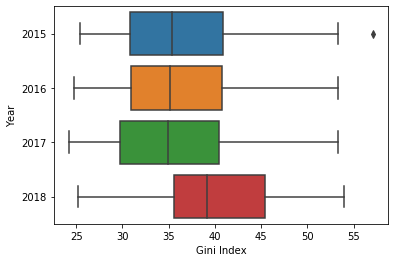

In [35]:
sns.boxplot(x="Gini Index", y="Year", data=df_timeseries)

### *Case Study Latin America*

To further explore Gini index and happiness score I decided to narrow my focus further and only look at a particular region of the world where data was available. Most countries in Latin America (11 in total) had four years of Gini index data so I decided to focus down and visual there Gini index data over the span of four years. To do this I created two line plots that show how the happiness of each of these countries has changed over time and how their Gini index has changed over time. I followed this up by creating two new columns that represent the difference between happiness score and Gini Index from 2015 to 2018. After plotting this data out I found that there is a very weak positive correlation with most Latin American countries having decreased both wealth inequality and Happiness score slightly. The positive correlation is largely due to Honduras being a country that has saw a sharp increase in both happiness and wealth inequality. In general, these results did not match my hypothesis that lowering wealth inequality would increase happiness. 

In [36]:
# countries of focus are latin American countries with sufficient data
latin_with_data = ['Bolivia','Brazil', 'Dominican Republic', 'Honduras', 'Panama', 'Costa Rica', 'Paraguay','Peru', 'Ecuador','Colombia','Uruguay']
latin_timeseries = df_timeseries[df_timeseries.Country.isin(latin_with_data)]
latin_timeseries['Year'] = latin_timeseries['Year'].astype(str)
latin_timeseries.value_counts('Country')

C:\Users\eddie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Country
Bolivia               4
Brazil                4
Colombia              4
Costa Rica            4
Dominican Republic    4
Ecuador               4
Honduras              4
Panama                4
Paraguay              4
Peru                  4
Uruguay               4
dtype: int64

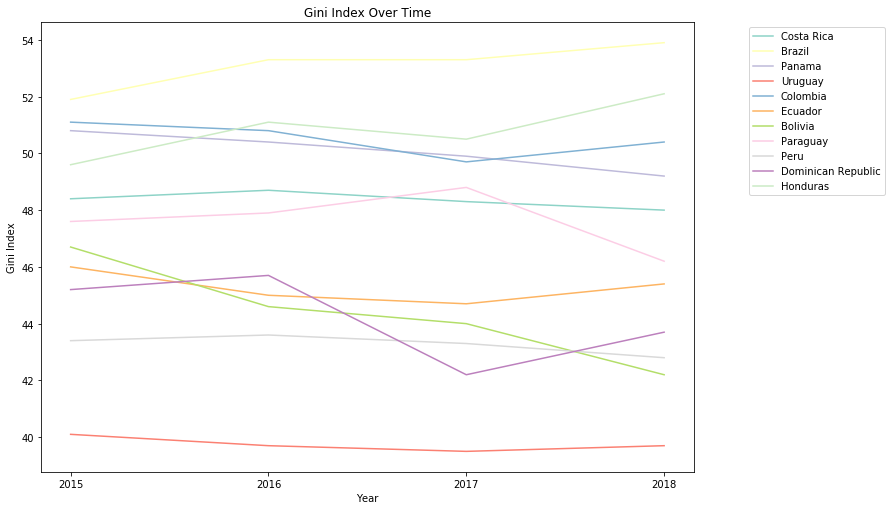

In [37]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
plt.title('Gini Index Over Time')

gini_timeseries = sns.lineplot(x="Year", y="Gini Index",
             hue="Country", palette='Set3', data=latin_timeseries)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))


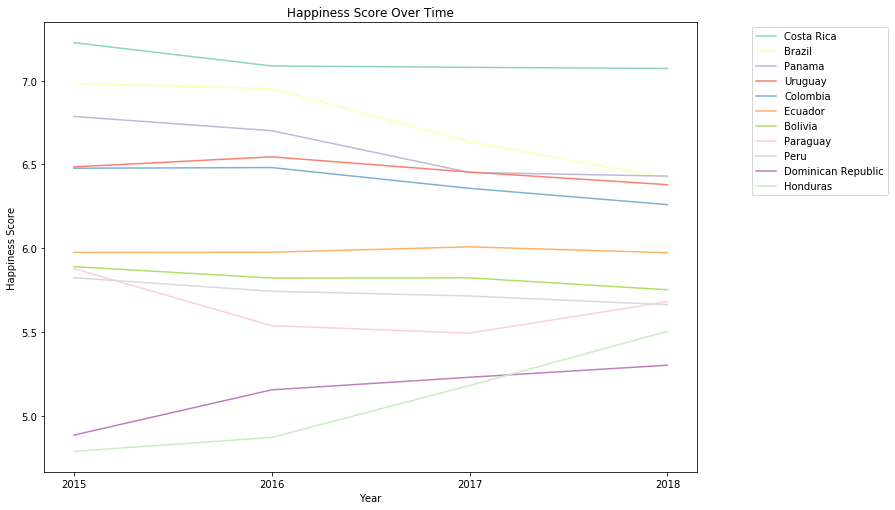

In [38]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
plt.title('Happiness Score Over Time')

happiness_timeseries = sns.lineplot(x="Year", y="Happiness Score",
             hue="Country", palette='Set3', data=latin_timeseries)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

In [39]:
# Difference Over Time

In [40]:
df['Gini Diff'] = df['Gini Index_2018'] - df['Gini Index_2015']
df['Happiness Diff'] = df['Happiness Score_2018'] - df['Happiness Score_2015']

In [41]:
latin_diff = df[df.Country.isin(latin_with_data)]
latin_diff = latin_diff[['Country','Gini Diff', 'Happiness Diff']]
latin_diff

,Country,Gini Diff,Happiness Diff
11,Costa Rica,-0.4,-0.154
15,Brazil,2.0,-0.564
23,Panama,-1.6,-0.356
30,Uruguay,-0.4,-0.106
31,Colombia,-0.7,-0.217
43,Ecuador,-0.6,-0.002
46,Bolivia,-4.5,-0.138
48,Paraguay,-1.4,-0.197
53,Peru,-0.6,-0.161
87,Dominican Republic,-1.5,0.417


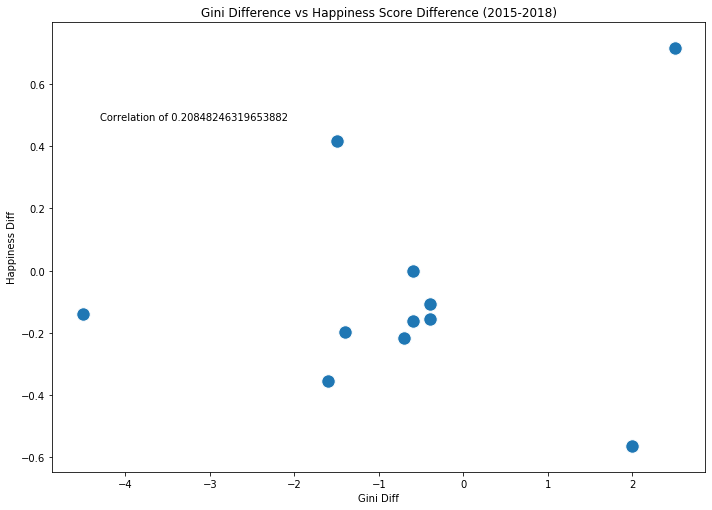

In [42]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
plt.title("Gini Difference vs Happiness Score Difference (2015-2018)")

correlation = latin_diff['Gini Diff'].corr(latin_diff['Happiness Diff'])
ax.annotate(f"Correlation of {correlation}", xy=(100,390), xycoords='figure points')

sns.scatterplot(ax=ax, data=latin_diff, x='Gini Diff',y='Happiness Diff', s=185)

# Conclusion

In conclusion, with data from the World Bank and World Happiness Report I have constructed a data story that looks at what data is available then tries to understand the connection between global happiness and wealth inequality/population growth. These visualizations cannot provide definitive proof of causation as there are too many confounding factors, but from what I have found, my initial hypothesizes that population and wealth inequality cause unhappiness are either untrue or overly simplistic.  